<a href="https://colab.research.google.com/github/who-knows-its-nebulose/chair-style-classifier/blob/main/Train_chair_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install split_folders
import splitfolders

In [3]:
# Split 70:15:15 into training, validation and test

splitfolders.ratio('/content/drive/My Drive/colabdownloads/chairs/', output="/content/drive/My Drive/DS_projects/chair_classifier/", seed=1337, ratio=(.7, 0.15,0.15))

Copying files: 1922 files [11:51,  2.70 files/s]


In [1]:
#Import libraries
import os
import numpy as np
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#variables
img_height = 224
img_width = 224
batch_size = 16

N_CLASSES = 4


#path
data_path = '/content/drive/My Drive/DS_projects/chair_classifier/'
train_data_path = data_path + 'train/'
val_data_path = data_path + 'val/'
test_data_path = data_path + 'test/'

#importing data
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                  #  width_shift_range=0.1,
                                  #  height_shift_range=0.1,
                                   shear_range=0.2,
                                   #zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle = False,
                                                        class_mode='categorical')




Found 1344 images belonging to 4 classes.
Found 287 images belonging to 4 classes.
Found 291 images belonging to 4 classes.


[0. 0. 0. 1.]


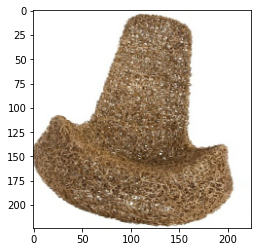

[1. 0. 0. 0.]


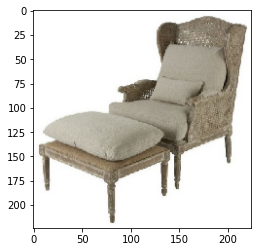

[1. 0. 0. 0.]


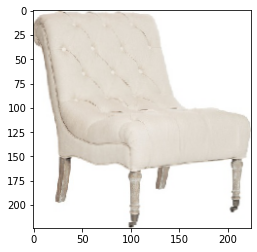

[0. 1. 0. 0.]


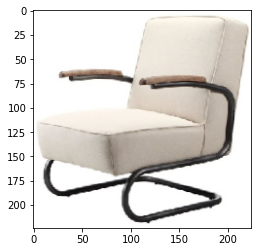

In [2]:
x,y = train_generator.next()
for i in range(0,4):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()
    

In [2]:

from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing



preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = 'max',
                                               alpha = 1.4)

base_model.trainable = False

# preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

# base_model = tf.keras.applications.InceptionResNetV2(
#     include_top=False,
#     weights="imagenet",
#     pooling='max',
#     input_shape=(img_height, img_width, 3)
#     )

# base_model.trainable = False

base_model.summary()




Model: "mobilenetv2_1.40_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 48) 192         Conv1[0][0]                      
_______________________________________________________________________________

In [3]:

#build model
kernel_init = tf.keras.initializers.glorot_uniform(seed=1337)
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
preprocessed_input = preprocess_input(inputs)
base_model_out = base_model(preprocessed_input, training=False)
# pooled = GlobalAveragePooling2D()(base_model_out)
# drop1 = Dropout(0.2)(pooled)
dense1 = Dense(256, activation = 'relu')(base_model_out)
drop2 = Dropout(0.3)(dense1)
dense2 = Dense(256, activation = 'relu')(drop2)
drop3 = Dropout(0.2)(dense2)
outputs = Dense(N_CLASSES, activation='softmax', kernel_initializer = kernel_init)(drop3)
model = tf.keras.Model(inputs, outputs)

model.summary()
len(model.trainable_variables)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

6

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/checkpoints_test/{epoch:02d}_{val_accuracy:.4f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1,    
    save_best_only=True)   
 
reduce_lr =  ReduceLROnPlateau(patience=4, monitor='val_accuracy', factor = 0.2 , min_lr=1e-7, verbose=1)

early_stopping = EarlyStopping(patience=8, monitor='val_accuracy', restore_best_weights=True, mode='max',verbose=1,min_delta=0.001)
          
Callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]    

In [5]:
TRAIN_DATASET_SIZE = len(train_generator)
VAL_DATASET_SIZE   = len(val_generator)

# Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.class_names, return_counts=True)
# class_weights = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))
#/content/drive/My Drive/Colab Notebooks


# Prepare model to run


base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
INITIAL_EPOCH = 0
TOTAL_EPOCHS = 50
# Start training the model
history = model.fit(train_generator,
                    epochs=TOTAL_EPOCHS,
                    verbose=1,
                    steps_per_epoch=TRAIN_DATASET_SIZE,
                    validation_data=val_generator,
                    validation_steps=VAL_DATASET_SIZE,
                    initial_epoch=INITIAL_EPOCH,
                    callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                    )

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 1.4452 - accuracy: 0.3676
Epoch 00001: val_accuracy improved from -inf to 0.49129, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/01_0.4913.h5
84/84 [==============================] - 19s 231ms/step - loss: 1.4452 - accuracy: 0.3676 - val_loss: 1.2146 - val_accuracy: 0.4913
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.2729 - accuracy: 0.4501
Epoch 00002: val_accuracy improved from 0.49129 to 0.50523, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/02_0.5052.h5
84/84 [==============================] - 18s 220ms/step - loss: 1.2729 - accuracy: 0.4501 - val_loss: 1.1864 - val_accuracy: 0.5052
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.4621
Epoch 00003: val_accuracy improved from 0.50523 to 0.51916, saving model to /content/drive/My Drive/Colab Notebooks/checkpoints_test/03_0.5192.h5
84/84 [============

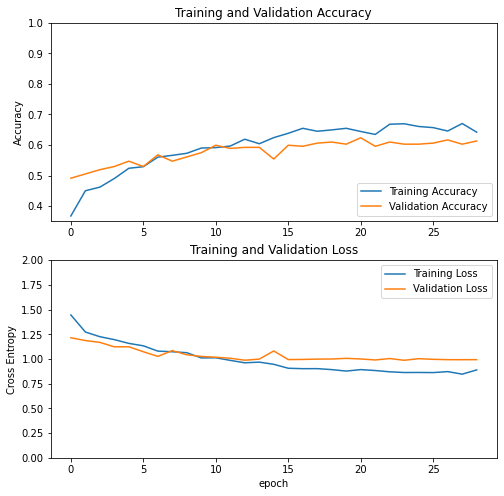

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [7]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

#num_of_test_samples = 261

Y_pred = model.predict(test_generator)#, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

#Mapping class indices to category names
labels = []
dict = (test_generator.class_indices)

for key, value in dict.items():
   labels.append(key)


print(classification_report(test_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[58 15  2 21]
 [16 52  5  8]
 [ 7 11 23  8]
 [ 7 13  3 42]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.66      0.60      0.63        96
  Industrial       0.57      0.64      0.60        81
  Midcentury       0.70      0.47      0.56        49
    Tropical       0.53      0.65      0.58        65

    accuracy                           0.60       291
   macro avg       0.61      0.59      0.59       291
weighted avg       0.61      0.60      0.60       291



In [8]:
chair_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints_test/'
if Path(chair_checkpoint_path).exists():
  epoch_number_array = []
  val_accuracy_array = []
  file_name_array = []
  for file in os.listdir(chair_checkpoint_path):
      epoch, val_ac = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
      epoch_number_array.append(int(epoch))
      val_accuracy_array.append(float(val_ac))
      file_name_array.append(file)

      if len(val_accuracy_array) == 0:
        INITIAL_EPOCH = 0
      else:
        highest_acc = val_accuracy_array.index(max(val_accuracy_array))
        INITIAL_EPOCH = epoch_number_array[highest_acc]
        model_checkpoint_callback.best = val_accuracy_array[highest_acc]
        model.load_weights(chair_checkpoint_path + file_name_array[highest_acc])
else:
  os.makedirs(chair_checkpoint_path)
  INITIAL_EPOCH = 0

In [9]:
print(val_accuracy_array[highest_acc])
print(INITIAL_EPOCH)

0.6237
21


In [10]:

#model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/checkpoints_test/16_0.6209.h5')
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

# model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = Adam(learning_rate=base_learning_rate/10),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  156
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dens

162

In [11]:
FINE_EPOCHS = 20


history_fine = model.fit(train_generator,
                        epochs=TOTAL_EPOCHS + FINE_EPOCHS,
                        verbose=1,
                        steps_per_epoch=TRAIN_DATASET_SIZE,
                        validation_data=val_generator,
                        validation_steps=VAL_DATASET_SIZE,
                        initial_epoch=INITIAL_EPOCH,
                        callbacks=[model_checkpoint_callback, reduce_lr, early_stopping]
                        )

Epoch 22/70
84/84 [==============================] - ETA: 0s - loss: 1.1888 - accuracy: 0.5164
Epoch 00022: val_accuracy did not improve from 0.62370
84/84 [==============================] - 19s 226ms/step - loss: 1.1888 - accuracy: 0.5164 - val_loss: 1.1181 - val_accuracy: 0.5331
Epoch 23/70
84/84 [==============================] - ETA: 0s - loss: 1.1260 - accuracy: 0.5312
Epoch 00023: val_accuracy did not improve from 0.62370
84/84 [==============================] - 18s 220ms/step - loss: 1.1260 - accuracy: 0.5312 - val_loss: 1.0824 - val_accuracy: 0.5366
Epoch 24/70
84/84 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.5766
Epoch 00024: val_accuracy did not improve from 0.62370
84/84 [==============================] - 19s 222ms/step - loss: 1.0245 - accuracy: 0.5766 - val_loss: 1.0937 - val_accuracy: 0.5679
Epoch 25/70
84/84 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.5930
Epoch 00025: val_accuracy improved from 0.62370 to 0.62718,

In [12]:
Y_pred = model.predict(test_generator)#, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

#Mapping class indices to category names
labels = []
dict = (test_generator.class_indices)

for key, value in dict.items():
   labels.append(key)


print(classification_report(test_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[61 14  8 13]
 [13 59  8  1]
 [ 1 14 31  3]
 [ 8 10  3 44]]
Classification Report
              precision    recall  f1-score   support

   Farmhouse       0.73      0.64      0.68        96
  Industrial       0.61      0.73      0.66        81
  Midcentury       0.62      0.63      0.63        49
    Tropical       0.72      0.68      0.70        65

    accuracy                           0.67       291
   macro avg       0.67      0.67      0.67       291
weighted avg       0.68      0.67      0.67       291



In [13]:
model.save('/content/drive/My Drive/DS_projects/chair_classifier/model_chair_classifier_finetuned.h5')


In [ ]:
#TEST
from keras.models import load_model
from keras.preprocessing import image
from skimage.io import imread
from skimage.transform import rescale, resize

model_trained = load_model('/content/drive/My Drive/DS_projects/chair_classifier/model_chair_classifier_finetuned.h5')




Enter your URLhttps://www.rstbrands.com/ProductImages/IP-MODCLB-JMS-PGB_main-1.jpg
[[0.03802624 0.04965952 0.90291744 0.00939674]]
Midcentury


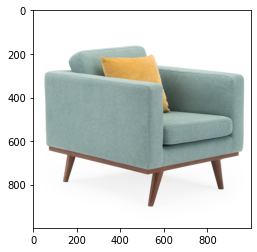

In [16]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)


Enter your URLhttps://s3.dutchcrafters.com/product-images/pid_57694-Amish-Reclaimed-Wood-Farmhouse-Chair--1590.jpg
[[0.6417006  0.12508357 0.13527165 0.09794416]]
Farmhouse


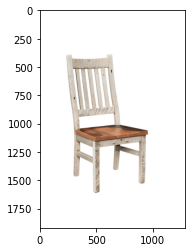

In [17]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)

Enter your URLhttps://cdn11.bigcommerce.com/s-ie82y90qzq/images/stencil/500x659/products/459/5880/818CH-DBLK-UD-PRV__33077.1591971503.jpg?c=2
[[0.01165322 0.93766624 0.00939865 0.04128183]]
Industrial


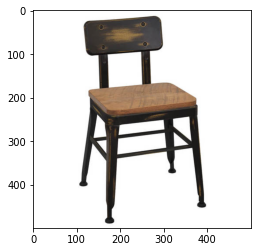

In [18]:
url = input('Enter your URL')
img = imread(url)
plt.imshow(img)
# class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical"]

img_resized = resize(img,(224,224,3))
img_batch = np.expand_dims(img_resized,axis=0)
prediction_prob_array = model_trained.predict(img_batch)
print(prediction_prob_array)

max_prob_index = prediction_prob_array.argmax(axis=-1)
prediction = labels[max_prob_index[0]]
print(prediction)